## Integrated OCR System

### Env Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install -r "/content/drive/My Drive/ocr_project/datasets/IAM_data/requirements.txt"
!apt-get install tesseract-ocr
!pip install pytesseract
!pip install azure-cognitiveservices-vision-computervision
!pip install keras-ocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.7/42.7 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 444.0/444.0 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 104.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.1/953.1 kB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 57.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 32 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (5,016 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121730 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [3]:
import cv2
import glob
import os
import numpy as np
from paddleocr import PaddleOCR
from autocorrect import Speller
import pytesseract
from azure.cognitiveservices.vision.computervision import ComputerVisionClient
from msrest.authentication import CognitiveServicesCredentials
import keras_ocr
from datasets import load_metric
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
import xml.etree.ElementTree as ET

In [5]:
import paddleocr
import pytesseract
import keras_ocr

print("PaddleOCR version:", paddleocr.__version__)
print("Pytesseract version:", pytesseract.__version__)
print("Keras OCR version:", keras_ocr.__version__)


PaddleOCR version: 2.7.0.2
Pytesseract version: 0.3.10
Keras OCR version: 0.9.3


### Model Comparison

#### Pipeline Define

In [ ]:
# Function to correct text using autocorrect
def correct_text(text, use_autocorrect):
    if use_autocorrect:
        spell = Speller(lang='en')
        return spell(text)
    else:
        return text

# Function to sort OCR results
def sort_ocr_results(ocr_result):
    # Sort by top coordinate, then by left coordinate
    # Flatten the list of lines
    all_words = [word_info for line in ocr_result for word_info in line]
    # Sort all words based on their Y coordinate, and then their X coordinate
    sorted_ocr = sorted(all_words, key=lambda x: (np.mean([pt[1] for pt in x[0]]), np.mean([pt[0] for pt in x[0]])))
    return sorted_ocr

# Function to process image with Tesseract and align output
def process_with_tesseract(img_path, use_autocorrect):
    image = cv2.imread(img_path)
    extracted_text = pytesseract.image_to_string(image, config='--psm 6')  # Using psm mode 6 to assume a single uniform block of text
    text_lines = [correct_text(line, use_autocorrect) for line in extracted_text.split('\n') if line.strip() != '']
    return text_lines


# Function to process image with Keras OCR and organize output by lines
def process_with_kerasocr(img_path, use_autocorrect):
    # Setup the pipeline
    pipeline = keras_ocr.pipeline.Pipeline()

    # Get the image
    image = keras_ocr.tools.read(img_path)

    # Use the pipeline to do OCR on the image
    prediction_groups = pipeline.recognize([image])

    # Sort the predictions by their Y coordinate, and then their X coordinate
    sorted_predictions = sorted(prediction_groups[0], key=lambda w: (np.mean([pt[1] for pt in w[1]]), np.mean([pt[0] for pt in w[1]])))

    # Group words by their line based on Y coordinate
    lines = []
    current_line = []
    last_y_mean = None
    y_threshold = 10  # Threshold to decide whether a word is on a new line

    for word, box in sorted_predictions:
        y_mean = np.mean([pt[1] for pt in box])

        # If this is the first word or it is close to the last word on Y axis, continue the line
        if last_y_mean is None or abs(y_mean - last_y_mean) < y_threshold:
            current_line.append(word)
        else:
            # Otherwise, start a new line
            lines.append(' '.join(current_line))
            current_line = [word]

        last_y_mean = y_mean

    # Add the last line if it's not empty
    if current_line:
        lines.append(' '.join(current_line))

    # Correct text if autocorrect is enabled
    if use_autocorrect:
        lines = [correct_text(line, use_autocorrect) for line in lines]

    return lines

# Function to process image with PaddleOCR
def process_with_paddleocr(img_path, use_autocorrect):
    ocr = PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True)
    result = ocr.ocr(img_path, cls=True)
    text_lines = []
    for line in result:
        for word_info in line:
            text = word_info[1][0]
            text_lines.append(correct_text(text, use_autocorrect))
    return text_lines

# Function to process image with Azure OCR
def process_with_azureocr(img_path, use_autocorrect, subscription_key, endpoint):
    computervision_client = ComputerVisionClient(
        endpoint, CognitiveServicesCredentials(subscription_key)
    )
    with open(img_path, "rb") as image_stream:
        response = computervision_client.read_in_stream(image_stream, raw=True)

    operation_location_remote = response.headers["Operation-Location"]
    operation_id = operation_location_remote.split("/")[-1]

    while True:
        get_printed_text_results = computervision_client.get_read_result(operation_id)
        if get_printed_text_results.status not in ['notStarted', 'running']:
            break

    text_lines = []
    if get_printed_text_results.status == 'succeeded':
        for text_result in get_printed_text_results.analyze_result.read_results:
            for line in text_result.lines:
                text_lines.append(correct_text(line.text, use_autocorrect))
    return text_lines

def create_output_directory(base_directory, model_name):
    # Define the directory path for the specific OCR model
    output_directory = os.path.join(base_directory, f"{model_name}_output")

    # Check if the directory exists, and if not, create it
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)

    return output_directory

def run_ocr_pipeline(dataset, use_autocorrect, apply_otsus, apply_canny, ocr_engine, base_directory):
    # Define the base directories for IAM and FUNSD datasets
    base_directories = {
        'IAM': '/content/drive/My Drive/ocr_project/datasets/IAM_data/test',
        'FUNSD': '/content/drive/My Drive/ocr_project/datasets/funsd_data'
    }

    # Choose the correct base directory
    base_directory = base_directories[dataset]

    # Determine the preprocessing suffix for the output file name
    preproc_suffix = ''
    if apply_otsus:
        sub_directory = "otsus_thresholded_images"
        preproc_suffix = 'otsus'
    elif apply_canny:
        sub_directory = "edge_detected_images"
        preproc_suffix = 'canny'
    else:
        sub_directory = "images"
        preproc_suffix = 'original'

    # Define the image input directory
    input_directory = os.path.join(base_directory, sub_directory)

    # Define the output directory based on the model name and preprocessing method
    output_directory = create_output_directory(base_directory, ocr_engine + '_' + preproc_suffix)

    # Search for .png files in the input directory
    image_files = glob.glob(os.path.join(input_directory, "*.png"))

    # Process each image file
    for img_path in image_files:
        base_name = os.path.basename(img_path).split('.')[0]
        output_file_name = f"{base_name}_{ocr_engine}_{preproc_suffix}_output.txt"
        output_path = os.path.join(output_directory, output_file_name)

        # Process the image with the selected OCR model
        if ocr_engine == 'PaddleOCR':
            ocr_results = process_with_paddleocr(img_path, use_autocorrect)
        elif ocr_engine == 'Tesseract':
            ocr_results = process_with_tesseract(img_path, use_autocorrect)
        elif ocr_engine == 'Keras':
            ocr_results = process_with_kerasocr(img_path, use_autocorrect)
        elif ocr_engine == 'AzureOCR':
            # You need to provide the subscription_key and endpoint for AzureOCR as parameters
            subscription_key = "73c3e6d6aa8e4569af0966805bde9e19"
            endpoint = "https://calvin.cognitiveservices.azure.com/"
            ocr_results = process_with_azureocr(img_path, use_autocorrect, subscription_key, endpoint)
        else:
            raise ValueError("Invalid OCR engine specified")

        # Write the OCR results to the output file
        with open(output_path, 'w') as f:
            for line in ocr_results:
                f.write(f"{line}\n")


#### Image preprocessing

##### Cany Edge Detector

In [ ]:
# Define your directories
IAM_directory = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/images"
FUNSD_directory = "/content/drive/My Drive/ocr_project/datasets/funsd_data/images"

# Function to process images with Canny Edge Detector
def process_images(directory):
    # Determine the parent directory
    parent_directory = os.path.dirname(directory)
    # Create a new directory for processed images
    processed_dir = os.path.join(parent_directory, "edge_detected_images")
    os.makedirs(processed_dir, exist_ok=True)

    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            image = cv2.imread(img_path, 0)  # Read the image in grayscale

            # Apply Canny Edge Detection
            edges = cv2.Canny(image, 100,200)

            # Save the processed image
            cv2.imwrite(os.path.join(processed_dir, filename), edges)

# Process images in both directories
process_images(IAM_directory)
process_images(FUNSD_directory)

print("Processing complete.")


In [ ]:
# Define the path to the image
image_path = '/content/drive/My Drive/ocr_project/datasets/IAM_data/test/edge_detected_images/a01-030.png'

# Open the image
image = Image.open(image_path).convert('RGB')

# Display the image
plt.imshow(image)
plt.axis('off') # Hide the axis to focus on the image
plt.show()

##### Ostu's Thresholding Method

In [ ]:


# Define your directories
IAM_directory = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/images"
FUNSD_directory = "/content/drive/My Drive/ocr_project/datasets/funsd_data/images"

# Function to apply Otsu's Thresholding
def apply_otsus_thresholding(directory):
    # Create a new directory for Otsu's thresholded images
    parent_directory = os.path.dirname(directory)
    otsus_dir = os.path.join(parent_directory, "otsus_thresholded_images")
    os.makedirs(otsus_dir, exist_ok=True)

    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            image = cv2.imread(img_path, 0)  # Read the image in grayscale

            # Apply Otsu's Thresholding
            _, thres_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Save the thresholded image
            cv2.imwrite(os.path.join(otsus_dir, filename), thres_image)

# Apply Otsu's Thresholding to both datasets
apply_otsus_thresholding(IAM_directory)
apply_otsus_thresholding(FUNSD_directory)

print("Otsu's thresholding complete.")


In [ ]:
# Define the path to the image
image_path = '/content/drive/My Drive/ocr_project/datasets/IAM_data/test/otsus_thresholded_images/a01-030.png'

# Open the image
image = Image.open(image_path).convert('RGB')

# Display the image
plt.imshow(image)
plt.axis('off') # Hide the axis to focus on the image
plt.show()

##### Both Methods

In [ ]:


# Define your directories
IAM_directory = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/edge_detected_images"
FUNSD_directory = "/content/drive/My Drive/ocr_project/datasets/funsd_data/edge_detected_images"

# Function to apply Otsu's Thresholding
def apply_otsus_thresholding(directory):
    # Create a new directory for Otsu's thresholded images
    parent_directory = os.path.dirname(directory)
    otsus_dir = os.path.join(parent_directory, "thresholded_edge_images")
    os.makedirs(otsus_dir, exist_ok=True)

    for filename in os.listdir(directory):
        if filename.endswith(".png"):
            img_path = os.path.join(directory, filename)
            image = cv2.imread(img_path, 0)  # Read the image in grayscale

            # Apply Otsu's Thresholding
            _, thres_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

            # Save the thresholded image
            cv2.imwrite(os.path.join(otsus_dir, filename), thres_image)

# Apply Otsu's Thresholding to both datasets
apply_otsus_thresholding(IAM_directory)
apply_otsus_thresholding(FUNSD_directory)

print("Process complete.")


In [ ]:
# Define the path to the image
image_path = '/content/drive/My Drive/ocr_project/datasets/IAM_data/test/thresholded_edge_images/a01-030.png'

# Open the image
image = Image.open(image_path).convert('RGB')

# Display the image
plt.imshow(image)
plt.axis('off') # Hide the axis to focus on the image
plt.show()

#### Run Pipeline
(only need to run once when first set-up as it's taking 1 hour to run through all)

##### **run ocr on raw IAM**

In [ ]:
## 14 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='Tesseract',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 18 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='Keras',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 8 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='PaddleOCR',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 5 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='AzureOCR',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

##### **run ocr on Cany edge IAM**

In [ ]:
## 4 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=True,
    ocr_engine='Tesseract',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 18 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=True,
    ocr_engine='Keras',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 6 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=True,
    ocr_engine='PaddleOCR',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 4 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=True,
    ocr_engine='AzureOCR',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

##### **run ocr on Otsus Thresholding IAM**

In [ ]:
## 3 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=True,
    apply_canny=False,
    ocr_engine='Tesseract',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 18 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=True,
    apply_canny=False,
    ocr_engine='Keras',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 6 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=True,
    apply_canny=False,
    ocr_engine='PaddleOCR',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 5 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=True,
    apply_canny=False,
    ocr_engine='AzureOCR',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

##### **run ocr on raw Funsd**

In [ ]:
# Specify Model and path to data
input_directory = "/content/drive/My Drive/ocr_project/datasets/funsd_data" ## 50 images

In [ ]:
model_name = "Tesseract"
output_directory = create_output_directory(input_directory, model_name)
run_ocr_pipeline(model_name, input_directory, use_autocorrect=False) ## Running time: 2min

In [ ]:
model_name = "Keras"
output_directory = create_output_directory(input_directory, model_name)
run_ocr_pipeline(model_name, input_directory, use_autocorrect=False) ## Running time: 9min

In [ ]:
model_name = "PaddleOCR"
output_directory = create_output_directory(input_directory, model_name)
run_ocr_pipeline(model_name, input_directory, use_autocorrect=False) ## Running time:3 mins

In [ ]:
subscription_key = "73c3e6d6aa8e4569af0966805bde9e19"
endpoint = "https://calvin.cognitiveservices.azure.com/"
model_name = "AzureOCR"
output_directory = create_output_directory(input_directory, model_name)
run_ocr_pipeline(model_name, input_directory, use_autocorrect=False, subscription_key = subscription_key, endpoint = endpoint) ## Running time: 2 min

##### **run ocr on raw Funsd**

In [ ]:
## 14 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='Tesseract',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 18 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='Keras',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 8 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='PaddleOCR',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 5 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='AzureOCR',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

##### **run ocr on Cany edge FUNSD**

In [ ]:
## 14 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='Tesseract',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 18 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='Keras',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 8 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='PaddleOCR',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 5 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='AzureOCR',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

##### **run ocr on Otsus Thresholding FUNSD**

In [ ]:
## 14 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='Tesseract',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 18 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='Keras',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 8 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='PaddleOCR',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

In [ ]:
# 5 mins to run
run_ocr_pipeline(
    dataset='IAM',
    use_autocorrect=False,
    apply_otsus=False,
    apply_canny=False,
    ocr_engine='AzureOCR',
    base_directory='/content/drive/My Drive/ocr_project/datasets'
)

### Result Inspection

In [ ]:
def display_image_and_ocr_output(base_directory, models, seed=None):
    # Set the seed for reproducibility if provided
    if seed is not None:
        random.seed(seed)

    # Define the directory where images are stored
    image_directory = os.path.join(base_directory, "images")

    # Gather all .png files in the directory
    image_files = [f for f in os.listdir(image_directory) if f.endswith(".png")]

    # Randomly select one image file
    selected_image_file = random.choice(image_files)
    img_path = os.path.join(image_directory, selected_image_file)

    # Display the image
    img = Image.open(img_path).convert('RGB')  # Convert the image to RGB
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Image: {selected_image_file}")
    plt.show()

    # Display the OCR output for each model
    for model_name in models:
        # Construct the path to the OCR output file
        ocr_output_dir = os.path.join(base_directory, f"{model_name}_output")
        ocr_output_file_base_name = os.path.splitext(selected_image_file)[0]
        ocr_output_file_name = f"{ocr_output_file_base_name}_{model_name}_output.txt"
        ocr_output_file_path = os.path.join(ocr_output_dir, ocr_output_file_name)

        print(f"--- OCR Output from {model_name} for {selected_image_file} ---")
        if os.path.exists(ocr_output_file_path):
            with open(ocr_output_file_path, 'r') as file:
                ocr_output = file.read()
                print(f"{ocr_output}\n")
        else:
            print(f"No OCR output found for {model_name}.\n")

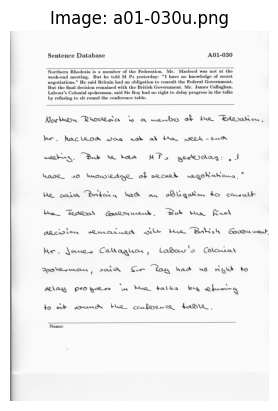

--- OCR Output from Tesseract for a01-030u.png ---
Sentence Database A01-030
Northern Rhodesia is a member of the Federation. Mr. Macleod was not at the
week-end meeting. But he told M Ps yesterday: ”I have no knowledge of secret
negotiations.” He said Britain had an obligation to consult the Federal Government.
But the final decision remained with the British Government. Mr. James Callaghan,
Labour’s Colonial spokesman, said Sir Roy had no right to delay progress in the talks
by refusing to sit round the conference table.
N * —- XQ
Nene wou “Roeder cr Ww Ww wae ded at hua RAQ OM eu ,
bie, hactrod& was nak al Mol weak —- end
wirglna “Bub tw hola MPs wes@rchay: , I
r 4 t
have uo knowledae_ of secwk unqgohabous, *
4 > ‘ . : A
MWe sarc ntarcy har ay eB gok eu tae cowl
us “FRARION Ga 2 wrrihe , “Bur Vag Riraak
e A 4 4 ‘
AQCADICN wQULcrusmr wh Mic “Bullish Goo wok
,
Moc ‘ \ ome Carraquonr ' La®oau SD Calcrra’d
Dea h8_2 WAC ; Carr or “Roy hak ug n A to
> 4
: a
to me vournnd Fae ceufmoerca 4B

In [ ]:
base_directory = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test"
models = ["Tesseract", "Keras", "PaddleOCR","AzureOCR"]  # List all models you want to display output from
seed = 42  # Change the seed to see different images
display_image_and_ocr_output(base_directory, models, seed)

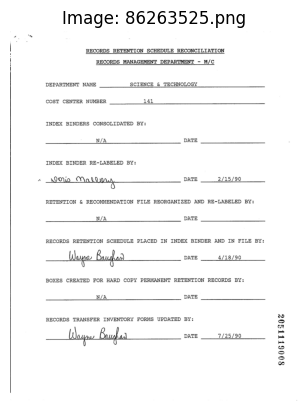

--- OCR Output from Tesseract for 86263525.png ---
| RECORDS RETENTION SCHEDULE RECONCILIATION
RECORDS MANAGEMENT DEPARTMENT - M/C
| DEPARTMENT NAME SCIENCE & TECHNOLOGY
COST CENTER NUMBER 141
INDEX BINDERS CONSOLIDATED BY:
N/A DATE
INDEX BINDER RE-LABELED BY:
« 9Mio Nod as DATE 2/15/90
RETENTION & RECOMMENDATION FILE REORGANIZED AND RE-LABELED BY:
N/A DATE
RECORDS RETENTION SCHEDULE PLACED IN INDEX BINDER AND IN FILE BY:
A faye be usd DATE 4/18/90
BOXES CREATED FOR HARD COPY PERMANENT RETENTION RECORDS BY:
N/A DATE
RECORDS TRANSFER INVENTORY FORMS UPDATED BY: s
oa
fg
DATE 7/25/90 a
me
©
o
=
o


--- OCR Output from Keras for 86263525.png ---
retention schedule records reconciliation
management department records mic
science s technology department name
141 number cost center
consolidated bys binders index
date nia
relabeled bys index binder
2115190 ooio date malls
file reorganized and reblabeled bys retention 8 recommendation
date nia
index binder and in file bys schedule placed in rec

In [ ]:
base_directory = "/content/drive/My Drive/ocr_project/datasets/funsd_data"
models = ["Tesseract", "Keras", "PaddleOCR","AzureOCR"]   # List all models you want to display output from
seed = 42  # Change the seed to see different images
display_image_and_ocr_output(base_directory, models, seed)

In [ ]:
import json

# Load the JSON data
with open('/content/drive/My Drive/ocr_project/datasets/funsd_data/annotations/82092117.json', 'r') as file:
    data = json.load(file)

# Extract the text from each entry and concatenate to form the ground truth text
ground_truth_text = ' '.join([entry['text'] for entry in data['form'] if entry['text'].strip() != ''])

ground_truth_text

"TO: DATE: 3 Fax: NOTE: 82092117 614 -466 -5087 Dec 10 '98 17 :46 P. 01 ATT. GEN. ADMIN. OFFICE Attorney General Betty D. Montgomery CONFIDENTIAL FACSIMILE TRANSMISSION COVER SHEET (614) 466- 5087 FAX NO. George Baroody (336) 335- 7392 FAX NUMBER: PHONE NUMBER: (336) 335- 7363 NUMBER OF PAGES INCLUDING COVER SHEET: June Flynn for Eric Brown/ (614) 466- 8980 SENDER /PHONE NUMBER: SPECIAL INSTRUCTIONS: IF YOU DO NOT RECEIVE ANY OF THE PAGES PROPERLY, PLEASE CONTACT SENDER AS SOON AS POSSIBLE THIS MESSAGE IS INTENDED ONLY FOR THE USE OF THE INDIVIDUAL OR ENTITY TO WHOM IT IS ADDRESSED AND MAY CONTAIN INFORMATION THAT IS PRIVILEGED. CONFIDENTIAL, AND EXEMPT FROM DISCLOSURE UNDER APPLICABLE LAW. If the reader of this message is not the intended recipient of the employee or agent responsible for delivering the message to the intended recipient, you are hereby notified that any dissemination, distribution, copying, or conveying of this communication in any manner is strictly prohibited. If yo

In [ ]:
with open('/content/drive/My Drive/ocr_project/datasets/funsd_data/AzureOCR_output/82092117_AzureOCR_output.txt', 'r') as file:
    data = file.read()
data

'-\nATT. GEN. ADMIN. OFFICE Fax:614-466-5087\nDec 10 \'98 17:46 P.01\nAttorney General\nBetty D. Montgomery\nTAL O\nCONFIDENTIAL FACSIMILE\nTRANSMISSION COVER SHEET\nFAX NO. (614) 466-5087\nTO: George Baroody\nFAX NUMBER:\n(336) 335-7392\nPHONE NUMBER: (336) 335-7363\nDATE:\n12/10/98\nNUMBER OF PAGES INCLUDING COVER SHEET:\n3\nSENDER/PHONE NUMBER:\nJune Flynn for Eric Brown/(614) 466-8980\nSPECIAL INSTRUCTIONS:\nIF YOU DO NOT RECEIVE ANY OF THE PAGES PROPERLY,\nPLEASE CONTACT SENDER\nAS SOON AS POSSIBLE\nNOTE:\nTHIS MESSAGE IS INTENDED ONLY FOR THE USE OF THE INDIVIDUAL OR ENTITY TO\nWHOM IT IS ADDRESSED AND MAY CONTAIN INFORMATION THAT IS PRIVILEGED,\nCONFIDENTIAL, AND EXEMPT FROM DISCLOSURE UNDER APPLICABLE LAW. If. the\nreader of this message is not the intended recipient of the employee or agent responsible for delivering\nthe message to the intended recipient, you are hereby notified that any dissemination, distribution,\ncopying, or conveying of this communication in any manner i

### Evaluation

#### Pipieline Definitioin

In [ ]:
#### Image and output prep pipeline
def process_ocr_data(base_folder, ocr_engine, preprocessing_methods):
    # Ensure preprocessing_methods is a list
    if isinstance(preprocessing_methods, str):
        preprocessing_methods = [preprocessing_methods]

    for preprocessing_method in preprocessing_methods:
        # Define directories based on OCR engine and preprocessing method
        ocr_output_dir = os.path.join(base_folder, f"{ocr_engine}_{preprocessing_method}_output")

        # Check if the directory exists
        if not os.path.exists(ocr_output_dir):
            print(f"Directory not found: {ocr_output_dir}")
            continue

        printed_output_dir = os.path.join(base_folder, f"{ocr_engine}_{preprocessing_method}_printed_output")
        writing_output_dir = os.path.join(base_folder, f"{ocr_engine}_{preprocessing_method}_writing_output")
        xml_dir = os.path.join(base_folder, "xml")

        # Make sure output directories exist
        os.makedirs(printed_output_dir, exist_ok=True)
        os.makedirs(writing_output_dir, exist_ok=True)

        # Process each file in the OCR output directory
        for output_file in os.listdir(ocr_output_dir):
            if output_file.endswith(f'{ocr_engine}_{preprocessing_method}_output.txt'):
                base_name = output_file.replace(f'_{ocr_engine}_{preprocessing_method}_output.txt', '')
                split_ocr_output(base_name, ocr_output_dir, printed_output_dir, writing_output_dir, xml_dir, ocr_engine)

def split_ocr_output(base_name, output_dir, printed_output_dir, writing_output_dir, xml_dir, ocr_engine):
    # Construct file paths
    output_file_path = os.path.join(output_dir, f"{base_name}_{ocr_engine}_{preprocessing_method}_output.txt")
    printed_output_file_path = os.path.join(printed_output_dir, f"{base_name}_printed_output.txt")
    writing_output_file_path = os.path.join(writing_output_dir, f"{base_name}_writing_output.txt")


    # Extract printed section from the OCR output file
    with open(output_file_path, 'r') as file:
        lines = file.readlines()
        stripped_lines = [line.strip() for line in lines]
        single_line_output_p = ' '.join(stripped_lines)

    # Write the single line output to the new output file
    with open(printed_output_file_path, 'w') as file:
        file.write(single_line_output_p + '\n')

    # Write the same output to the handwriting file (as there's no specific split)
    with open(writing_output_file_path, 'w') as file:
        file.write(single_line_output_p + '\n')


In [ ]:

def calculate_tp_fp_fn(prediction, reference):
    tp = sum(1 for pred_char, ref_char in zip(prediction, reference) if pred_char == ref_char)
    fp = len(prediction) - tp
    fn = len(reference) - tp
    return tp, fp, fn

def calculate_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
    accuracy = tp / (tp + fp + fn) if tp + fp + fn != 0 else 0
    return accuracy, precision, recall, f1

def evaluate_ocr(dataset, ocr_engine, output_type, preprocess):
    if dataset == 'IAM':
      base_dir = '/content/drive/My Drive/ocr_project/datasets/IAM_data/test/'
      reference_dir = os.path.join(base_dir, 'printed_label')
      if preprocess == 'raw':
        prediction_dir = os.path.join(base_dir, f'{ocr_engine}_{output_type}_output')
      elif preprocess == 'cany':
        prediction_dir = os.path.join(base_dir, f'{ocr_engine}_{preprocess}_{output_type}_output')
      elif preprocess == 'otsus':
        prediction_dir = os.path.join(base_dir, f'{ocr_engine}_{preprocess}_{output_type}_output')
      else:
        return 'Invalid preprocessing method. Please try again.'
    elif dataset == "FUNSD":  # FUNSD
      base_dir = '/content/drive/My Drive/ocr_project/datasets/funsd_data/'
      reference_dir = os.path.join(base_dir, 'label')
      if preprocess == 'raw':
        prediction_dir = os.path.join(base_dir, f'{ocr_engine}_output')
      elif preprocess == 'cany':
        prediction_dir = os.path.join(base_dir, f'{ocr_engine}_{preprocess}_output')
      elif preprocess == 'otsus':
        prediction_dir = os.path.join(base_dir, f'{ocr_engine}_{preprocess}_output')
      else:
        return 'Invalid preprocessing method. Please try again.'

    accuracies, precisions, recalls, f1s, cers, wers = [], [], [], [], [], []

    cer_metric = load_metric('cer')
    wer_metric = load_metric('wer')

    for prediction_file in os.listdir(prediction_dir):
        if prediction_file.endswith('_printed_output.txt'):
            prediction_path = os.path.join(prediction_dir, prediction_file)
            base_name = prediction_file.replace('_printed_output.txt', '')
            reference_file = base_name + '_printed_label.txt'
            reference_path = os.path.join(reference_dir, reference_file)
        if prediction_file.endswith('_writing_output.txt'):
            prediction_path = os.path.join(prediction_dir, prediction_file)
            base_name = prediction_file.replace('_writing_output.txt', '')
            reference_file = base_name + '_printed_label.txt'
            reference_path = os.path.join(reference_dir, reference_file)

            with open(prediction_path, 'r') as file:
                prediction = file.read().strip()
            with open(reference_path, 'r') as file:
                reference = file.read().strip()

            tp, fp, fn = calculate_tp_fp_fn(prediction, reference)
            accuracy, precision, recall, f1 = calculate_metrics(tp, fp, fn)

            accuracies.append(accuracy)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)

            cers.append(cer_metric.compute(predictions=[prediction], references=[reference]))
            wers.append(wer_metric.compute(predictions=[prediction], references=[reference]))

    metrics = {
        "Accuracy": (np.mean(accuracies), np.std(accuracies)),
        "Precision": (np.mean(precisions), np.std(precisions)),
        "Recall": (np.mean(recalls), np.std(recalls)),
        "F1 Score": (np.mean(f1s), np.std(f1s)),
        "CER": (np.mean(cers), np.std(cers)),
        "WER": (np.mean(wers), np.std(wers))
    }

    return metrics

# Example usage:
# base_dir = '/content/drive/My Drive/ocr_project/datasets/IAM_data/test/'
# dataset = 'IAM'  # or 'FUNSD'
# ocr_engine = 'paddle'  # choose from 'tesseract', 'keras', 'paddle', 'azure', 'integrated'
# output_type = 'printed'  # choose from 'writing', 'printed'
# preprocess = 'raw'  # choose from 'raw', 'cany', 'otsus'
# metrics = evaluate_ocr(dataset, ocr_engine, output_type, preprocess)
# for metric, (mean, std) in metrics.items():
#     print(f"{metric}: Mean = {mean}, Standard Deviation = {std}")


#### Dataset Label and OCR Output Prep

In [ ]:
# Example usage
base_folder = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test"
ocr_engine = "Tesseract"  # Could be Keras, PaddleOCR, AzureOCR
preprocessing_methods = "canny"

process_ocr_data(base_folder, ocr_engine, preprocessing_methods)

##### Backup

In [ ]:
base_folder = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test"
ocr_engine = "Tesseract"  # Could be Keras, PaddleOCR, AzureOCR
preprocessing_method = "canny"  # Could be otsus

process_ocr_data(base_folder, ocr_engine, preprocessing_method)

In [ ]:
# Function to split the OCR output into printed and handwriting sections
def split_ocr_output(base_name, lines_to_skip, output_dir, printed_output_dir, writing_output_dir, xml_dir, ocr_engine):
    output_file_path = os.path.join(output_dir, f"{base_name}_{ocr_engine}_output.txt")
    printed_output_file_path = os.path.join(printed_output_dir, f"{base_name}_printed_output.txt")
    writing_output_file_path = os.path.join(writing_output_dir, f"{base_name}_writing_output.txt")

    # Extract printed section from the OCR output file
    with open(output_file_path, 'r') as file:
        lines = file.readlines()[lines_to_skip:]  # Take all lines after the lines to skip
        stripped_lines = [line.strip() for line in lines]
        single_line_output_p = ' '.join(stripped_lines)

    # Write the single line output to the new output file
    with open(printed_output_file_path, 'w') as file:
        file.write(single_line_output_p + '\n')

    # Write the same output to the handwriting file (as there's no specific split)
    with open(writing_output_file_path, 'w') as file:
        file.write(single_line_output_p + '\n')

# Function to create stripped printed label from XML
def create_stripped_label(base_name, xml_dir, stripped_label_dir):
    xml_file_path = os.path.join(xml_dir, base_name + '.xml')
    stripped_label_file_path = os.path.join(stripped_label_dir, base_name + '_stripped_label.txt')

    if not os.path.exists(stripped_label_file_path):  # Create label only if it doesn't exist
        # Parse the XML file
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        machine_printed_part = root.find('machine-printed-part')
        if machine_printed_part is not None:
            machine_print_lines = machine_printed_part.findall('machine-print-line')
            printed_text = ' '.join([line.attrib['text'] for line in machine_print_lines])

            # Write the processed text to the new label file
            with open(stripped_label_file_path, 'w') as file:
                file.write(printed_text)

# Main Script
base_directory = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test"
xml_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/xml"
stripped_label_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/stripped_label"
os.makedirs(stripped_label_dir, exist_ok=True)  # Ensure the stripped_label directory exists

output_dirs = {
    'Tesseract': 1,
    'Keras':1,
    'PaddleOCR': 2,
    'AzureOCR': 2
}

for ocr_engine, lines_to_skip in output_dirs.items():
    output_dir = os.path.join(base_directory, f"{ocr_engine}_output")
    printed_output_dir = os.path.join(output_dir, "printed_output")
    writing_output_dir = os.path.join(output_dir, "writing_output")
    os.makedirs(printed_output_dir, exist_ok=True)
    os.makedirs(writing_output_dir, exist_ok=True)

    for output_file in os.listdir(output_dir):
        if output_file.endswith(f'{ocr_engine}_output.txt'):
            base_name = output_file.replace(f'_{ocr_engine}_output.txt', '')
            split_ocr_output(base_name, lines_to_skip, output_dir, printed_output_dir, writing_output_dir, xml_dir, ocr_engine)
            create_stripped_label(base_name, xml_dir, stripped_label_dir)

print("Preprocessing for all OCR engines completed.")

Preprocessing for all OCR engines completed.


In [ ]:
xml_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/xml"
printed_label_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/printed_label"
########################### Tesseract ########################################
# Set up the directories
output_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/Tesseract_output"
printed_output_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/tesseract_printed_output"
writing_output_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/tesseract_writing_output"

# Make sure the new directories exist
os.makedirs(printed_output_dir, exist_ok=True)
os.makedirs(writing_output_dir, exist_ok=True)
os.makedirs(printed_label_dir, exist_ok=True)

# List all the files in the output directory
for output_file in os.listdir(output_dir):
    if output_file.endswith('_Tesseract_output.txt'):
        base_name = output_file.replace('_Tesseract_output.txt', '')
        xml_file_path = os.path.join(xml_dir, base_name + '.xml')
        output_file_path = os.path.join(output_dir, output_file)
        printed_output_file_path = os.path.join(printed_output_dir, base_name + '_printed_output.txt')
        writing_output_file_path = os.path.join(writing_output_dir, base_name + '_writing_output.txt')
        printed_label_file_path = os.path.join(printed_label_dir, base_name + '_printed_label.txt')

        # Parse the XML file to determine how many lines to extract
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        machine_printed_part = root.find('machine-printed-part')
        if machine_printed_part is not None:
            machine_print_lines = machine_printed_part.findall('machine-print-line')
            x = len(machine_print_lines)  # This is how many lines we want to extract

            # Extract printed section from the OCR output file
            with open(output_file_path, 'r') as file:
                lines = file.readlines()[1:x+1]  # Skip the first 1 line and take x lines
                stripped_lines = [line.strip() for line in lines]
                single_line_output_p = ' '.join(stripped_lines)

            # Write the single line output to the new output file
            with open(printed_output_file_path, 'w') as file:
              file.write(single_line_output_p + '\n')

            # Extract writing from the OCR output file
            with open(output_file_path, 'r') as file:
                lines = file.readlines()[x+1:-2]
                stripped_lines = [line.strip() for line in lines]
                single_line_output_w = ' '.join(stripped_lines)
            # Write the single line output to the new output file
            with open(writing_output_file_path, 'w') as file:
              file.write(single_line_output_w + '\n')

            # Process the XML file to extract only the machine printed text
            printed_text = ' '.join([line.attrib['text'] for line in machine_print_lines])

            # Write the processed text to the new label file
            with open(printed_label_file_path, 'w') as file:
                file.write(printed_text)

print("Preprocessing completed for Tesseract OCR.")

########################### Tesseract ########################################
# Set up the directories
output_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/Keras_output"
printed_output_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/keras_printed_output"
writing_output_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/keras_writing_output"

# Make sure the new directories exist
os.makedirs(printed_output_dir, exist_ok=True)
os.makedirs(writing_output_dir, exist_ok=True)
os.makedirs(printed_label_dir, exist_ok=True)

# List all the files in the output directory
for output_file in os.listdir(output_dir):
    if output_file.endswith('_Keras_output.txt'):
        base_name = output_file.replace('_Keras_output.txt', '')
        xml_file_path = os.path.join(xml_dir, base_name + '.xml')
        output_file_path = os.path.join(output_dir, output_file)
        printed_output_file_path = os.path.join(printed_output_dir, base_name + '_printed_output.txt')
        writing_output_file_path = os.path.join(writing_output_dir, base_name + '_writing_output.txt')
        printed_label_file_path = os.path.join(printed_label_dir, base_name + '_printed_label.txt')

        # Parse the XML file to determine how many lines to extract
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        machine_printed_part = root.find('machine-printed-part')
        if machine_printed_part is not None:
            machine_print_lines = machine_printed_part.findall('machine-print-line')
            x = len(machine_print_lines)  # This is how many lines we want to extract

            # Extract printed section from the OCR output file
            with open(output_file_path, 'r') as file:
                lines = file.readlines()[1:x+1]  # Skip the first 1 line and take x lines
                stripped_lines = [line.strip() for line in lines]
                single_line_output_p = ' '.join(stripped_lines)

            # Write the single line output to the new output file
            with open(printed_output_file_path, 'w') as file:
              file.write(single_line_output_p + '\n')

            # Extract writing from the OCR output file
            with open(output_file_path, 'r') as file:
                lines = file.readlines()[x+1:-2]
                stripped_lines = [line.strip() for line in lines]
                single_line_output_w = ' '.join(stripped_lines)
            # Write the single line output to the new output file
            with open(writing_output_file_path, 'w') as file:
              file.write(single_line_output_w + '\n')

            # Process the XML file to extract only the machine printed text
            printed_text = ' '.join([line.attrib['text'] for line in machine_print_lines])

            # Write the processed text to the new label file
            with open(printed_label_file_path, 'w') as file:
                file.write(printed_text)

print("Preprocessing completed for Keras OCR.")



########################### PADDLE ########################################
# Set up the directories
output_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/PaddleOCR_output"
printed_output_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/paddle_printed_output"
writing_output_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/paddle_writing_output"

# Make sure the new directories exist
os.makedirs(printed_output_dir, exist_ok=True)
os.makedirs(writing_output_dir, exist_ok=True)
os.makedirs(printed_label_dir, exist_ok=True)

# List all the files in the output directory
for output_file in os.listdir(output_dir):
    if output_file.endswith('_PaddleOCR_output.txt'):
        base_name = output_file.replace('_PaddleOCR_output.txt', '')
        xml_file_path = os.path.join(xml_dir, base_name + '.xml')
        output_file_path = os.path.join(output_dir, output_file)
        printed_output_file_path = os.path.join(printed_output_dir, base_name + '_printed_output.txt')
        writing_output_file_path = os.path.join(writing_output_dir, base_name + '_writing_output.txt')
        printed_label_file_path = os.path.join(printed_label_dir, base_name + '_printed_label.txt')

        # Parse the XML file to determine how many lines to extract
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        machine_printed_part = root.find('machine-printed-part')
        if machine_printed_part is not None:
            machine_print_lines = machine_printed_part.findall('machine-print-line')
            x = len(machine_print_lines)  # This is how many lines we want to extract

            # Extract printed section from the OCR output file
            with open(output_file_path, 'r') as file:
                lines = file.readlines()[2:x+2]  # Skip the first 2 line and take x lines
                stripped_lines = [line.strip() for line in lines]
                single_line_output_p = ' '.join(stripped_lines)

            # Write the single line output to the new output file
            with open(printed_output_file_path, 'w') as file:
              file.write(single_line_output_p + '\n')

            # Extract writing from the OCR output file
            with open(output_file_path, 'r') as file:
                lines = file.readlines()[x+2:-1]
                stripped_lines = [line.strip() for line in lines]
                single_line_output_w = ' '.join(stripped_lines)
            # Write the single line output to the new output file
            with open(writing_output_file_path, 'w') as file:
              file.write(single_line_output_w + '\n')

            # Process the XML file to extract only the machine printed text
            printed_text = ' '.join([line.attrib['text'] for line in machine_print_lines])

            # Write the processed text to the new label file
            with open(printed_label_file_path, 'w') as file:
                file.write(printed_text)

print("Preprocessing completed for Paddle OCR.")


########################### Azure ########################################

# Set up the directories
output_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/AzureOCR_output"
printed_output_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/azure_printed_output"
writing_output_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/azure_writing_output"

# Make sure the new directories exist
os.makedirs(printed_output_dir, exist_ok=True)
os.makedirs(writing_output_dir, exist_ok=True)
os.makedirs(printed_label_dir, exist_ok=True)

# List all the files in the output directory
for output_file in os.listdir(output_dir):
    if output_file.endswith('_AzureOCR_output.txt'):
        base_name = output_file.replace('_AzureOCR_output.txt', '')
        xml_file_path = os.path.join(xml_dir, base_name + '.xml')
        output_file_path = os.path.join(output_dir, output_file)
        printed_output_file_path = os.path.join(printed_output_dir, base_name + '_printed_output.txt')
        writing_output_file_path = os.path.join(writing_output_dir, base_name + '_writing_output.txt')
        printed_label_file_path = os.path.join(printed_label_dir, base_name + '_printed_label.txt')

        # Parse the XML file to determine how many lines to extract
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        machine_printed_part = root.find('machine-printed-part')
        if machine_printed_part is not None:
            machine_print_lines = machine_printed_part.findall('machine-print-line')
            x = len(machine_print_lines)  # This is how many lines we want to extract

            # Extract printed section from the OCR output file
            with open(output_file_path, 'r') as file:
                lines = file.readlines()[2:x+2]  # Skip the first 2 line and take x lines
                stripped_lines = [line.strip() for line in lines]
                single_line_output_p = ' '.join(stripped_lines)

            # Write the single line output to the new output file
            with open(printed_output_file_path, 'w') as file:
              file.write(single_line_output_p + '\n')

            # Extract writing from the OCR output file
            with open(output_file_path, 'r') as file:
                lines = file.readlines()[x+2:-1]
                stripped_lines = [line.strip() for line in lines]
                single_line_output_w = ' '.join(stripped_lines)
            # Write the single line output to the new output file
            with open(writing_output_file_path, 'w') as file:
              file.write(single_line_output_w + '\n')

            # Process the XML file to extract only the machine printed text
            printed_text = ' '.join([line.attrib['text'] for line in machine_print_lines])

            # Write the processed text to the new label file
            with open(printed_label_file_path, 'w') as file:
                file.write(printed_text)

print("Preprocessing completed for Azure OCR.")



Preprocessing completed for Tesseract OCR.
Preprocessing completed for Keras OCR.
Preprocessing completed for Paddle OCR.
Preprocessing completed for Azure OCR.


#### **Performance Evaluation**

##### **IAM Printed**

**Tesseract on raw**

In [ ]:
dataset_type = 'IAM'  # or 'FUNSD'
ocr_engine = 'tesseract'  # or 'tesseract', 'keras', 'azure', 'integrated'
output_type = 'printed'  # or 'writing', 'raw', 'edge', 'threshold'
metrics = evaluate_ocr(dataset_type, ocr_engine, output_type, preprocess = 'raw')
for metric, (mean, std) in metrics.items():
  print(f"{metric}: Mean = {mean}, Standard Deviation = {std}")

Accuracy: Mean = 0.6065334070524334, Standard Deviation = 0.4416836781924128
Precision: Mean = 0.6421733400010031, Standard Deviation = 0.41811244257528885
Recall: Mean = 0.6390674282591154, Standard Deviation = 0.4207742436641794
F1 Score: Mean = 0.6403561096229138, Standard Deviation = 0.41978658783362827
CER: Mean = 0.0398493813316577, Standard Deviation = 0.12613499913091952
WER: Mean = 0.056164789456899525, Standard Deviation = 0.14973979504913207


**Keras on raw**

In [ ]:
dataset_type = 'IAM'  # or 'FUNSD'
ocr_engine = 'keras'  # or 'tesseract', 'keras', 'azure', 'integrated'
output_type = 'printed'  # or 'writing', 'raw', 'edge', 'threshold'
metrics = evaluate_ocr(dataset_type, ocr_engine, output_type, preprocess = 'raw')
for metric, (mean, std) in metrics.items():
  print(f"{metric}: Mean = {mean}, Standard Deviation = {std}")

Accuracy: Mean = 0.04539655119082459, Standard Deviation = 0.014264072998261811
Precision: Mean = 0.08777660426734897, Standard Deviation = 0.026065909604933265
Recall: Mean = 0.0852739063745469, Standard Deviation = 0.02560518859602367
F1 Score: Mean = 0.08649812919869167, Standard Deviation = 0.02582275648196267
CER: Mean = 0.5951973331991199, Standard Deviation = 0.05639310271481885
WER: Mean = 0.8022153334697141, Standard Deviation = 0.07352060897910216


**Paddle on raw**

In [ ]:
dataset_type = 'IAM'  # or 'FUNSD'
ocr_engine = 'paddle'  # or 'tesseract', 'keras', 'azure', 'integrated'
output_type = 'printed'  # or 'writing', 'raw', 'edge', 'threshold'
metrics = evaluate_ocr(dataset_type, ocr_engine, output_type, preprocess = 'raw')
for metric, (mean, std) in metrics.items():
  print(f"{metric}: Mean = {mean}, Standard Deviation = {std}")

Accuracy: Mean = 0.4780620077033381, Standard Deviation = 0.3986385882841659
Precision: Mean = 0.5549574405907098, Standard Deviation = 0.3636396455531435
Recall: Mean = 0.5443459594600577, Standard Deviation = 0.3684939606718958
F1 Score: Mean = 0.5492032265400723, Standard Deviation = 0.3661640799511978
CER: Mean = 0.07977240762504785, Standard Deviation = 0.14512842582794475
WER: Mean = 0.09967314560818591, Standard Deviation = 0.1494870596955262


**Azure on raw**

In [ ]:
dataset_type = 'IAM'  # or 'FUNSD'
ocr_engine = 'azure'  # or 'tesseract', 'keras', 'azure', 'integrated'
output_type = 'printed'  # or 'writing', 'raw', 'edge', 'threshold'
metrics = evaluate_ocr(dataset_type, ocr_engine, output_type, preprocess = 'raw')
for metric, (mean, std) in metrics.items():
  print(f"{metric}: Mean = {mean}, Standard Deviation = {std}")

Accuracy: Mean = 0.7991246748869599, Standard Deviation = 0.3518115196475703
Precision: Mean = 0.8290797348836768, Standard Deviation = 0.31148465037110973
Recall: Mean = 0.8259479560399883, Standard Deviation = 0.3148893325214776
F1 Score: Mean = 0.8274748761369841, Standard Deviation = 0.3132049925430551
CER: Mean = 0.011566950536449494, Standard Deviation = 0.023205705103573487
WER: Mean = 0.012431493666398629, Standard Deviation = 0.02405603524626999


##### **IAM Handwriting**

**Tesseract on raw**

In [ ]:
dataset_type = 'IAM'  # or 'FUNSD'
ocr_engine = 'tesseract'  # or 'tesseract', 'keras', 'azure', 'integrated'
output_type = 'writing'  # or 'printed', 'writing'
preprocess = 'raw' # or 'raw', 'cany', 'otsus'
metrics = evaluate_ocr(dataset_type, ocr_engine, output_type, preprocess = 'raw')
for metric, (mean, std) in metrics.items():
  print(f"{metric}: Mean = {mean}, Standard Deviation = {std}")

Accuracy: Mean = 0.04354116575285482, Standard Deviation = 0.026716431469195227
Precision: Mean = 0.09125729218741957, Standard Deviation = 0.04667318880034697
Recall: Mean = 0.07747027784988907, Standard Deviation = 0.047233328163982
F1 Score: Mean = 0.0822536843843428, Standard Deviation = 0.04672277151299142
CER: Mean = 0.5788178631324882, Standard Deviation = 0.1817562692093086
WER: Mean = 1.0382194976497834, Standard Deviation = 0.2515411142775698


**Keras on raw**

In [ ]:
dataset_type = 'IAM'  # or 'FUNSD'
ocr_engine = 'keras'  # or 'tesseract', 'keras', 'azure', 'integrated'
output_type = 'writing'  # or 'printed', 'writing'
preprocess = 'raw' # or 'raw', 'cany', 'otsus'
metrics = evaluate_ocr(dataset_type, ocr_engine, output_type, preprocess = 'raw')
for metric, (mean, std) in metrics.items():
  print(f"{metric}: Mean = {mean}, Standard Deviation = {std}")

Accuracy: Mean = 0.03843164217260561, Standard Deviation = 0.011231581633114709
Precision: Mean = 0.07961961475080089, Standard Deviation = 0.021284409903936402
Recall: Mean = 0.06913837110151982, Standard Deviation = 0.020750661879288493
F1 Score: Mean = 0.07379482255093806, Standard Deviation = 0.02069500230181294
CER: Mean = 0.6827357873109224, Standard Deviation = 0.04878165333756581
WER: Mean = 1.0210533637350863, Standard Deviation = 0.09418020856605291


**Paddle on raw**

In [ ]:
dataset_type = 'IAM'  # or 'FUNSD'
ocr_engine = 'paddle'  # or 'tesseract', 'keras', 'azure', 'integrated'
output_type = 'writing'  # or 'printed', 'writing'
preprocess = 'raw' # or 'raw', 'cany', 'otsus'
metrics = evaluate_ocr(dataset_type, ocr_engine, output_type, preprocess = 'raw')
for metric, (mean, std) in metrics.items():
  print(f"{metric}: Mean = {mean}, Standard Deviation = {std}")

Accuracy: Mean = 0.04250124275132867, Standard Deviation = 0.04137734400389826
Precision: Mean = 0.09538581155384356, Standard Deviation = 0.06687801453060378
Recall: Mean = 0.06955734361699095, Standard Deviation = 0.06649284761348294
F1 Score: Mean = 0.07888027689739789, Standard Deviation = 0.0671713303194596
CER: Mean = 0.47534101696381736, Standard Deviation = 0.2020935890641295
WER: Mean = 0.7899529498222843, Standard Deviation = 0.17091018147649106


**Azure on raw**

In [ ]:
dataset_type = 'IAM'  # or 'FUNSD'
ocr_engine = 'azure'  # or 'tesseract', 'keras', 'azure', 'integrated'
output_type = 'writing'  # or 'printed', 'writing'
preprocess = 'raw' # or 'raw', 'cany', 'otsus'
metrics = evaluate_ocr(dataset_type, ocr_engine, output_type, preprocess = 'raw')
for metric, (mean, std) in metrics.items():
  print(f"{metric}: Mean = {mean}, Standard Deviation = {std}")

Accuracy: Mean = 0.1502923378948146, Standard Deviation = 0.15615394764757684
Precision: Mean = 0.2396753121131249, Standard Deviation = 0.17470991494831858
Recall: Mean = 0.238054285596106, Standard Deviation = 0.1725221731452413
F1 Score: Mean = 0.23849501547980523, Standard Deviation = 0.17280484506210295
CER: Mean = 0.07789967876434024, Standard Deviation = 0.09641223216318859
WER: Mean = 0.2778541543827156, Standard Deviation = 0.12434971337447001


##### Backup

In [ ]:
# Load the metrics
cer_metric = load_metric('cer')
wer_metric = load_metric('wer')

# Paths to your directories
predictionp_printed_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/paddle_printed_output"
predictionp_writing_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/paddle_writing_output"
reference_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/printed_label"

# Initialize lists for predictions and references
prediction_printed_texts = []
prediction_writing_texts = []
reference_texts = []

# Iterate over files in the predictions directory
for prediction_file in os.listdir(predictionp_printed_dir):
    if prediction_file.endswith('_printed_output.txt'):
        # Construct file paths
        prediction_path = os.path.join(predictionp_printed_dir, prediction_file)
        base_name = prediction_file.replace('_printed_output.txt', '')
        reference_file = base_name + '_printed_label.txt'
        reference_path = os.path.join(reference_dir, reference_file)

        # Read prediction and reference texts
        with open(prediction_path, 'r') as file:
            prediction_printed_texts.append(file.read().strip())

        with open(reference_path, 'r') as file:
            reference_texts.append(file.read().strip())

for prediction_file in os.listdir(predictionp_writing_dir):
    if prediction_file.endswith('_writing_output.txt'):
        # Construct file paths
        prediction_path = os.path.join(predictionp_writing_dir, prediction_file)
        base_name = prediction_file.replace('_writing_output.txt', '')
        reference_file = base_name + '_printed_label.txt'
        reference_path = os.path.join(reference_dir, reference_file)

        # Read prediction and reference texts
        with open(prediction_path, 'r') as file:
            prediction_writing_texts.append(file.read().strip())

        with open(reference_path, 'r') as file:
            reference_texts.append(file.read().strip())

# Calculate CER and WER for each prediction-reference pair
printed_cer_scores = [cer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_printed_texts, reference_texts)]
printed_wer_scores = [wer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_printed_texts, reference_texts)]
writing_cer_scores = [cer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_writing_texts, reference_texts)]
writing_wer_scores = [wer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_writing_texts, reference_texts)]

# Calculate the average scores
avg_cer_p = sum(printed_cer_scores) / len(printed_cer_scores)
avg_wer_p= sum(printed_wer_scores) / len(printed_wer_scores)
avg_cer_w= sum(writing_cer_scores) / len(writing_cer_scores)
avg_wer_w= sum(writing_wer_scores) / len(writing_wer_scores)

print(f"Average Character Error Rate (CER) for Paddle Printed Texts: {avg_cer_p}")
print(f"Average Word Error Rate (WER) for Paddle Printed Texts:{avg_wer_p}")
print(f"Average Character Error Rate (CER) for Paddle Hand-writing Texts: {avg_cer_w}")
print(f"Average Word Error Rate (WER) for Paddle Hand-writing Texts: {avg_wer_w}")


Average Character Error Rate (CER) for Paddle Printed Texts: 0.07977240762504786
Average Word Error Rate (WER) for Paddle Printed Texts:0.0996731456081859
Average Character Error Rate (CER) for Paddle Hand-writing Texts: 0.6252587168720688
Average Word Error Rate (WER) for Paddle Hand-writing Texts: 0.891081624843624


In [ ]:

def calculate_tp_fp_fn(prediction, reference):
    tp = sum(1 for pred_char, ref_char in zip(prediction, reference) if pred_char == ref_char)
    fp = len(prediction) - tp
    fn = len(reference) - tp
    return tp, fp, fn

def calculate_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if tp + fp != 0 else 0
    recall = tp / (tp + fn) if tp + fn != 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if precision + recall != 0 else 0
    accuracy = tp / (tp + fp + fn) if tp + fp + fn != 0 else 0
    return accuracy, precision, recall, f1

# Paths to your directories
predictionp_printed_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/paddle_printed_output"
reference_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/printed_label"

# Initialize lists to store metrics for each file
accuracies, precisions, recalls, f1s = [], [], [], []

# Iterate over files and calculate metrics
for prediction_file in os.listdir(predictionp_printed_dir):
    if prediction_file.endswith('_printed_output.txt'):
        prediction_path = os.path.join(predictionp_printed_dir, prediction_file)
        base_name = prediction_file.replace('_printed_output.txt', '')
        reference_file = base_name + '_printed_label.txt'
        reference_path = os.path.join(reference_dir, reference_file)

        with open(prediction_path, 'r') as file:
            prediction = file.read().strip()

        with open(reference_path, 'r') as file:
            reference = file.read().strip()

        tp, fp, fn = calculate_tp_fp_fn(prediction, reference)
        accuracy, precision, recall, f1 = calculate_metrics(tp, fp, fn)

        accuracies.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1s.append(f1)

# Calculate the average of each metric
avg_accuracy = sum(accuracies) / len(accuracies)
avg_precision = sum(precisions) / len(precisions)
avg_recall = sum(recalls) / len(recalls)
avg_f1 = sum(f1s) / len(f1s)

print(f"Average Accuracy: {avg_accuracy}, Average Precision: {avg_precision}, Average Recall: {avg_recall}, Average F1 Score: {avg_f1}")


Average Accuracy: 0.47806200770333784, Average Precision: 0.55495744059071, Average Recall: 0.5443459594600577, Average F1 Score: 0.5492032265400721


**Azure Performance**

In [ ]:
# Load the metrics
cer_metric = load_metric('cer')
wer_metric = load_metric('wer')

# Paths to your directories
predictionp_printed_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/azure_printed_output"
predictionp_writing_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/azure_writing_output"
reference_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/printed_label"

# Initialize lists for predictions and references
prediction_printed_texts = []
prediction_writing_texts = []
reference_texts = []

# Iterate over files in the predictions directory
for prediction_file in os.listdir(predictionp_printed_dir):
    if prediction_file.endswith('_printed_output.txt'):
        # Construct file paths
        prediction_path = os.path.join(predictionp_printed_dir, prediction_file)
        base_name = prediction_file.replace('_printed_output.txt', '')
        reference_file = base_name + '_printed_label.txt'
        reference_path = os.path.join(reference_dir, reference_file)

        # Read prediction and reference texts
        with open(prediction_path, 'r') as file:
            prediction_printed_texts.append(file.read().strip())

        with open(reference_path, 'r') as file:
            reference_texts.append(file.read().strip())

for prediction_file in os.listdir(predictionp_writing_dir):
    if prediction_file.endswith('_writing_output.txt'):
        # Construct file paths
        prediction_path = os.path.join(predictionp_writing_dir, prediction_file)
        base_name = prediction_file.replace('_writing_output.txt', '')
        reference_file = base_name + '_printed_label.txt'
        reference_path = os.path.join(reference_dir, reference_file)

        # Read prediction and reference texts
        with open(prediction_path, 'r') as file:
            prediction_writing_texts.append(file.read().strip())

        with open(reference_path, 'r') as file:
            reference_texts.append(file.read().strip())

# Calculate CER and WER for each prediction-reference pair
printed_cer_scores = [cer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_printed_texts, reference_texts)]
printed_wer_scores = [wer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_printed_texts, reference_texts)]
writing_cer_scores = [cer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_writing_texts, reference_texts)]
writing_wer_scores = [wer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_writing_texts, reference_texts)]

# Calculate the average scores
avg_cer_p = sum(printed_cer_scores) / len(printed_cer_scores)
avg_wer_p= sum(printed_wer_scores) / len(printed_wer_scores)
avg_cer_w= sum(writing_cer_scores) / len(writing_cer_scores)
avg_wer_w= sum(writing_wer_scores) / len(writing_wer_scores)

print(f"Average Character Error Rate (CER) for Azure Printed Texts: {avg_cer_p}")
print(f"Average Word Error Rate (WER) for Azure Printed Texts:{avg_wer_p}")
print(f"Average Character Error Rate (CER) for Azure Hand-writing Texts: {avg_cer_w}")
print(f"Average Word Error Rate (WER) for Azure Hand-writing Texts: {avg_wer_w}")


Average Character Error Rate (CER) for Azure Printed Texts: 0.011566950536449494
Average Word Error Rate (WER) for Azure Printed Texts:0.01243149366639863
Average Character Error Rate (CER) for Azure Hand-writing Texts: 0.07789967876434024
Average Word Error Rate (WER) for Azure Hand-writing Texts: 0.27785415438271555


**Tesseract Performance**

In [ ]:
# Load the metrics
cer_metric = load_metric('cer')
wer_metric = load_metric('wer')

# Paths to your directories
predictionp_printed_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/tesseract_printed_output"
predictionp_writing_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/tesseract_writing_output"
reference_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/printed_label"

# Initialize lists for predictions and references
prediction_printed_texts = []
prediction_writing_texts = []
reference_texts = []

# Iterate over files in the predictions directory
for prediction_file in os.listdir(predictionp_printed_dir):
    if prediction_file.endswith('_printed_output.txt'):
        # Construct file paths
        prediction_path = os.path.join(predictionp_printed_dir, prediction_file)
        base_name = prediction_file.replace('_printed_output.txt', '')
        reference_file = base_name + '_printed_label.txt'
        reference_path = os.path.join(reference_dir, reference_file)

        # Read prediction and reference texts
        with open(prediction_path, 'r') as file:
            prediction_printed_texts.append(file.read().strip())

        with open(reference_path, 'r') as file:
            reference_texts.append(file.read().strip())

for prediction_file in os.listdir(predictionp_writing_dir):
    if prediction_file.endswith('_writing_output.txt'):
        # Construct file paths
        prediction_path = os.path.join(predictionp_writing_dir, prediction_file)
        base_name = prediction_file.replace('_writing_output.txt', '')
        reference_file = base_name + '_printed_label.txt'
        reference_path = os.path.join(reference_dir, reference_file)

        # Read prediction and reference texts
        with open(prediction_path, 'r') as file:
            prediction_writing_texts.append(file.read().strip())

        with open(reference_path, 'r') as file:
            reference_texts.append(file.read().strip())

# Calculate CER and WER for each prediction-reference pair
printed_cer_scores = [cer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_printed_texts, reference_texts)]
printed_wer_scores = [wer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_printed_texts, reference_texts)]
writing_cer_scores = [cer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_writing_texts, reference_texts)]
writing_wer_scores = [wer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_writing_texts, reference_texts)]

# Calculate the average scores
avg_cer_p = sum(printed_cer_scores) / len(printed_cer_scores)
avg_wer_p= sum(printed_wer_scores) / len(printed_wer_scores)
avg_cer_w= sum(writing_cer_scores) / len(writing_cer_scores)
avg_wer_w= sum(writing_wer_scores) / len(writing_wer_scores)

print(f"Average Character Error Rate (CER) for Tesseract Printed Texts: {avg_cer_p}")
print(f"Average Word Error Rate (WER) for Tesseract Printed Texts:{avg_wer_p}")
print(f"Average Character Error Rate (CER) for Tesseract Hand-writing Texts: {avg_cer_w}")
print(f"Average Word Error Rate (WER) for Tesseract Hand-writing Texts: {avg_wer_w}")


Average Character Error Rate (CER) for Tesseract Printed Texts: 0.03984938133165769
Average Word Error Rate (WER) for Tesseract Printed Texts:0.056164789456899525
Average Character Error Rate (CER) for Tesseract Hand-writing Texts: 0.5788178631324881
Average Word Error Rate (WER) for Tesseract Hand-writing Texts: 1.0382194976497836


**Keras Performance**

In [ ]:
# Load the metrics
cer_metric = load_metric('cer')
wer_metric = load_metric('wer')

# Paths to your directories
predictionp_printed_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/keras_printed_output"
predictionp_writing_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/keras_writing_output"
reference_dir = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/printed_label"

# Initialize lists for predictions and references
prediction_printed_texts = []
prediction_writing_texts = []
reference_texts = []

# Iterate over files in the predictions directory
for prediction_file in os.listdir(predictionp_printed_dir):
    if prediction_file.endswith('_printed_output.txt'):
        # Construct file paths
        prediction_path = os.path.join(predictionp_printed_dir, prediction_file)
        base_name = prediction_file.replace('_printed_output.txt', '')
        reference_file = base_name + '_printed_label.txt'
        reference_path = os.path.join(reference_dir, reference_file)

        # Read prediction and reference texts
        with open(prediction_path, 'r') as file:
            prediction_printed_texts.append(file.read().strip())

        with open(reference_path, 'r') as file:
            reference_texts.append(file.read().strip())

for prediction_file in os.listdir(predictionp_writing_dir):
    if prediction_file.endswith('_writing_output.txt'):
        # Construct file paths
        prediction_path = os.path.join(predictionp_writing_dir, prediction_file)
        base_name = prediction_file.replace('_writing_output.txt', '')
        reference_file = base_name + '_printed_label.txt'
        reference_path = os.path.join(reference_dir, reference_file)

        # Read prediction and reference texts
        with open(prediction_path, 'r') as file:
            prediction_writing_texts.append(file.read().strip())

        with open(reference_path, 'r') as file:
            reference_texts.append(file.read().strip())

# Calculate CER and WER for each prediction-reference pair
printed_cer_scores = [cer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_printed_texts, reference_texts)]
printed_wer_scores = [wer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_printed_texts, reference_texts)]
writing_cer_scores = [cer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_writing_texts, reference_texts)]
writing_wer_scores = [wer_metric.compute(predictions=[pred], references=[ref]) for pred, ref in zip(prediction_writing_texts, reference_texts)]

# Calculate the average scores
avg_cer_p = sum(printed_cer_scores) / len(printed_cer_scores)
avg_wer_p= sum(printed_wer_scores) / len(printed_wer_scores)
avg_cer_w= sum(writing_cer_scores) / len(writing_cer_scores)
avg_wer_w= sum(writing_wer_scores) / len(writing_wer_scores)

print(f"Average Character Error Rate (CER) for Keras Printed Texts: {avg_cer_p}")
print(f"Average Word Error Rate (WER) for Keras Printed Texts:{avg_wer_p}")
print(f"Average Character Error Rate (CER) for Keras Hand-writing Texts: {avg_cer_w}")
print(f"Average Word Error Rate (WER) for Keras Hand-writing Texts: {avg_wer_w}")


Average Character Error Rate (CER) for Keras Printed Texts: 0.5951973331991195
Average Word Error Rate (WER) for Keras Printed Texts:0.8022153334697139
Average Character Error Rate (CER) for Keras Hand-writing Texts: 0.6827357873109225
Average Word Error Rate (WER) for Keras Hand-writing Texts: 1.0210533637350863


In [ ]:
!pip install Levenshtein

     |████████████████████████████████| 169 kB 2.7 MB/s            
     |████████████████████████████████| 3.4 MB 9.4 MB/s            
  Attempting uninstall: rapidfuzz
    Found existing installation: rapidfuzz 2.13.7
    Uninstalling rapidfuzz-2.13.7:
      Successfully uninstalled rapidfuzz-2.13.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jiwer 3.0.2 requires rapidfuzz==2.13.7, but you have rapidfuzz 3.6.1 which is incompatible.


### Integrated System

#### Scoring System

In [ ]:
# Load the metrics
cer_metric = load_metric('cer')
wer_metric = load_metric('wer')

# Function to calculate average CER/WER for chunks of 10 words
def calculate_average_cer_wer(ocr_output, ground_truth):
    # Split the output and ground truth into chunks of 10 words
    ocr_chunks = [' '.join(ocr_output[i:i+10]) for i in range(0, len(ocr_output), 10)]
    ground_truth_chunks = [' '.join(ground_truth[i:i+10]) for i in range(0, len(ground_truth), 10)]

    # Calculate CER/WER for each chunk
    cer_scores = [cer_metric.compute(predictions=[chunk], references=[gt_chunk]) for chunk, gt_chunk in zip(ocr_chunks, ground_truth_chunks)]
    wer_scores = [wer_metric.compute(predictions=[chunk], references=[gt_chunk]) for chunk, gt_chunk in zip(ocr_chunks, ground_truth_chunks)]

    # Calculate the average scores
    avg_cer = sum(cer_scores) / len(cer_scores)
    avg_wer = sum(wer_scores) / len(wer_scores)

    return avg_cer, avg_wer

# Function to calculate CER/WER for chunks of 10 words
def calculate_cer_wer(ocr_chunk, ground_truth_chunk):
    # Calculate CER/WER for each chunk
    cer_score = cer_metric.compute(predictions=ocr_chunk, references=ground_truth_chunk)
    wer_score = wer_metric.compute(predictions=ocr_chunk, references=ground_truth_chunk)
    return cer_score, wer_score

# Function to process image with Azure OCR
def process_with_azureocr(img_path, use_autocorrect, subscription_key, endpoint):
    # Authenticate the client
    computervision_client = ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key))

    # Read the image file
    with open(img_path, "rb") as image_stream:
        # Call API to extract text
        response = computervision_client.read_in_stream(image_stream, raw=True)

    # Get the operation location (URL with an ID at the end)
    operation_location_remote = response.headers["Operation-Location"]
    operation_id = operation_location_remote.split("/")[-1]

    # Call the "GET" API and wait for it to retrieve the results
    while True:
        get_printed_text_results = computervision_client.get_read_result(operation_id)
        if get_printed_text_results.status not in ['notStarted', 'running']:
            break

    # Extract text
    text_output = []
    if get_printed_text_results.status == 'succeeded':
        for text_result in get_printed_text_results.analyze_result.read_results:
            for line in text_result.lines:
                text_output.append(line.text)

    # Correct text if autocorrect is enabled
    if use_autocorrect:
        text_output = [correct_text(text, use_autocorrect) for text in text_output]

    return text_output


# Function to process the image with each OCR system
def process_image_with_ocr_systems(image_path, ground_truth_text, subscription_key, endpoint):
    # Initialize the OCR systems
    ocr_engines = {
        'PaddleOCR': PaddleOCR(use_angle_cls=True, lang='en', use_gpu=True),
        'Tesseract': pytesseract,
        'AzureOCR': ComputerVisionClient(endpoint, CognitiveServicesCredentials(subscription_key)) # Uncomment and configure for Azure
    }

    # Initialize a dictionary to store the results
    ocr_results = {}

    # Process the image with PaddleOCR
    paddle_result = ocr_engines['PaddleOCR'].ocr(image_path, cls=True)
    ocr_results['PaddleOCR'] = [' '.join([word_info[1][0] for line in paddle_result for word_info in line])]

    # Process the image with Tesseract
    image = cv2.imread(image_path)
    tesseract_result = ocr_engines['Tesseract'].image_to_string(image)
    ocr_results['Tesseract'] = tesseract_result.strip().split()

    # Process the image with Azure
    azure_result = process_with_azureocr(image_path, False, subscription_key, endpoint)
    ocr_results['AzureOCR'] = azure_result

    # Split the ground truth text into chunks of 10 words
    ground_truth_words = ground_truth_text.split()
    ground_truth_chunks = [' '.join(ground_truth_words[i:i+10]) for i in range(0, len(ground_truth_words), 10)]

    # Select the best OCR output for each chunk based on CER/WER
    best_chunk_outputs = []
    for i in range(0, len(ground_truth_words), 10):
        chunk_scores = {}
        for model_name, text_output in ocr_results.items():
            ocr_chunk = ' '.join(text_output[i:i+10])
            gt_chunk = ground_truth_chunks[i // 10]  # Get the corresponding ground truth chunk
            chunk_scores[model_name] = calculate_cer_wer([ocr_chunk], [gt_chunk])

        # Select the OCR model with the lowest score for this chunk
        best_model = min(chunk_scores, key=chunk_scores.get)
        best_chunk = ' '.join(ocr_results[best_model][i:i+10])
        best_chunk_outputs.append(best_chunk)

    # Combine the best chunks to form the final output
    final_output = ' '.join(best_chunk_outputs)
    return final_output

In [ ]:
# Example usage
image_path = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/test_image/a01-030u.png"
ground_truth_path = "/content/drive/My Drive/ocr_project/datasets/IAM_data/test/printed_label/a01-030u_printed_label.txt"
subscription_key = "73c3e6d6aa8e4569af0966805bde9e19"
endpoint = "https://calvin.cognitiveservices.azure.com/"
# Load the ground truth text
with open(ground_truth_path, 'r') as gt_file:
    ground_truth_text = gt_file.read().strip()

# Process the image and get the best OCR output
final_output = process_image_with_ocr_systems(image_path, ground_truth_text, subscription_key, endpoint)
print(final_output)

[2024/01/05 02:27:53] ppocr DEBUG: Namespace(help='==SUPPRESS==', use_gpu=True, use_xpu=False, use_npu=False, ir_optim=True, use_tensorrt=False, min_subgraph_size=15, precision='fp32', gpu_mem=500, gpu_id=0, image_dir=None, page_num=0, det_algorithm='DB', det_model_dir='/root/.paddleocr/whl/det/en/en_PP-OCRv3_det_infer', det_limit_side_len=960, det_limit_type='max', det_box_type='quad', det_db_thresh=0.3, det_db_box_thresh=0.6, det_db_unclip_ratio=1.5, max_batch_size=10, use_dilation=False, det_db_score_mode='fast', det_east_score_thresh=0.8, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_sast_score_thresh=0.5, det_sast_nms_thresh=0.2, det_pse_thresh=0, det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, scales=[8, 16, 32], alpha=1.0, beta=1.0, fourier_degree=5, rec_algorithm='SVTR_LCNet', rec_model_dir='/root/.paddleocr/whl/rec/en/en_PP-OCRv4_rec_infer', rec_image_inverse=True, rec_image_shape='3, 48, 320', rec_batch_num=6, max_text_length=25, rec_char_dict_path='/

#### Evaluation